In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
from graphviz import Digraph

def draw_dot(root):
    def trace(root):
        # builds a set of all nodes and edges in a graph
        nodes, edges = set(), set()

        def build(root):
            if root not in nodes:
                nodes.add(root)
                for child in root.prev:
                    edges.add((child, root))
                    build(child)

        build(root)
        return nodes, edges

    dot = Digraph(graph_attr={'rankdir': 'LR'}, format='svg')

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid,
                 label="{ %s | data=%0.4f | grad=%0.4f}" % (
                     node.name, node.val, node.grad),
                 shape='record')

        if node.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + node.op, label=node.op)
            # and connect this node to it
            dot.edge(uid + node.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot


In [25]:
from __future__ import annotations
from cmath import isfinite
from typing import List, Union
import uuid


class Scalar:
    def __init__(self,
                 val: Union[float, int],
                 name: str = '',
                 prev: tuple[Scalar] = (),
                 op: str = '') -> None:

        assert isinstance(
            val, (float, int)), "val must be a float or an integer"

        self.val = val
        self.name = name
        self.prev = set(prev)
        self.op = op
        self.grad = 0.0
        self._backward = lambda: None

    def exp(self) -> Scalar:
        x = self.val
        output = Scalar(math.exp(x), prev=(self, ), op='exp')
        
        def _backward():
            self.grad += output.val * output.grad
        output._backward = _backward

        return output

    def tanh(self) -> Scalar:
        x = self.val
        tanh = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Scalar(tanh, prev=(self, ), op='tanh')

        def _backward():
            self.grad += (1.0 - tanh**2) * output.grad
        output._backward = _backward 

        return output 

    def backward(self) -> None:
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __add__(self, other) -> Scalar:
        other = other if isinstance(other, Scalar) else Scalar(other)
        output = Scalar(self.val + other.val, prev=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        output._backward = _backward 

        return output

    def __mul__(self, other) -> Scalar:
        other = other if isinstance(other, Scalar) else Scalar(other)
        output = Scalar(self.val * other.val, prev=(self, other), op='*')

        def _backward():
            self.grad += other.val * output.grad
            other.grad += self.val * output.grad
        output._backward = _backward 

        return output 

    def __radd__(self, other) -> Scalar:
        return self + other

    def __rmul__(self, other) -> Scalar:
        return self * other

    def __neg__(self) -> Scalar:
        return self * -1

    def __sub__(self, other) -> Scalar:
        return self + (-other)

    def __rsub__(self, other) -> Scalar:
        return other + (-self)

    def __pow__(self, other) -> Scalar:
        assert isinstance(
            other, (float, int)), 'class Scalar can only be raised by the power of an integer or a float'
        
        output = Scalar(self.val ** other, prev=(self, ), op=f'**{other}')

        def _backward():
            self.grad += other * self.val ** (other - 1) * output.grad
        output._backward = _backward

        return output 

    def __truediv__(self, other) -> Scalar:
        return self * other ** -1

    def __rtruediv__(self, other) -> Scalar:
        return other * self ** -1

    def __repr__(self) -> str:
        return f'Scalar(val={self.val:0.4f}, grad={self.grad:0.4f})'


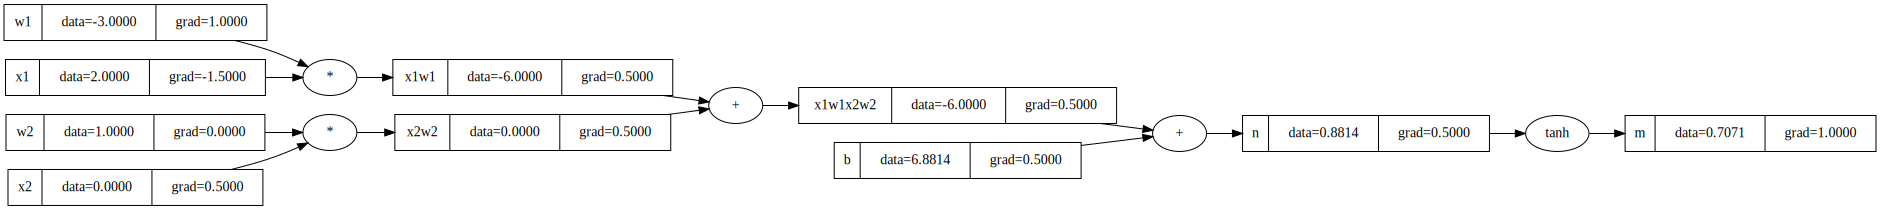

In [26]:
# inputs x1, x2
x1 = Scalar(2.0, name='x1')
x2 = Scalar(0.0, name='x2')
# weights w1, w2,
w1 = Scalar(-3.0, name='w1')
w2 = Scalar(1.0, name='w2')
# bias
b = Scalar(6.8813735, name='b')

x1w1 = x1 * w1
x1w1.name = 'x1w1'
x2w2 = x2 * w2
x2w2.name = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.name = 'x1w1x2w2'
n = x1w1x2w2 + b
n.name = 'n'
m = n.tanh()
m.name = 'm'
m.backward()
draw_dot(m)

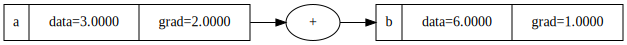

In [27]:
a = Scalar(3.0, name='a')
b = a + a
b.name = 'b'
b.backward()
draw_dot(b)

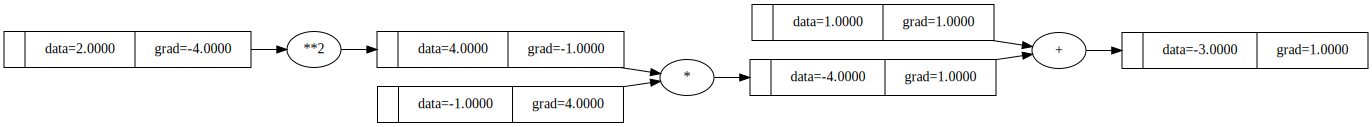

In [28]:
a = Scalar(1.0)
a.exp()
b = Scalar(2.0)
c = b**2
d = a - c
d.backward()
draw_dot(d)